# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [10]:
import numpy as np
import pandas as pd
from typing import List, Tuple, Iterable
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

Ворнинги уже задолбали, поэтому оффнем их

In [11]:
import warnings

warnings.filterwarnings("ignore")

In [12]:
data = pd.read_csv('train.csv')

In [13]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [15]:
na = data.shape[0] - data.count()
na[na > 0]

keyword       61
location    2533
dtype: int64

In [16]:
data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Видим, что есть пропуски в колонках `keyword, location`, обе - типа object , причем в `location` их довольно много (треть датасета). Заполним их по заданию - пустыми строчками

In [17]:
data = data.fillna('')
print(data.isna().any().any())
data.head()

False


,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


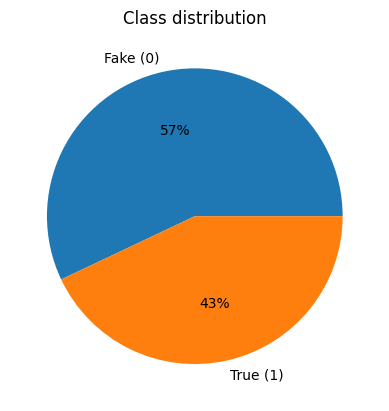

In [18]:
plt.title('Class distribution')
plt.pie(data['target'].value_counts(), labels=['Fake (0)', 'True (1)'], autopct='%0.0f%%')
plt.show()

Видно, что текстов (твитов) относительно целевой переменной примерно поровну (57% / 43% фейковых/настоящих твитов, если быть ~~точным~~ душным). Датасет в этом плане оч хороший 

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [19]:
top10 = data['keyword'].value_counts(sort=True, ascending=False)[:10].index
top10

Index(['', 'fatalities', 'deluge', 'armageddon', 'sinking', 'damage', 'harm',
       'body%20bags', 'evacuate', 'fear'],
      dtype='object')

Видим, что пустая строчка является самым популярным ключевым словом, это не есть хорошо. Поэтому просто добавим еще одну проверку и получим только существющие ключевые слова 

In [20]:
top10 = data[data['keyword'] != '']['keyword'].value_counts(sort=True, ascending=False)[:10].index
top10

Index(['fatalities', 'deluge', 'armageddon', 'sinking', 'damage', 'harm',
       'body%20bags', 'outbreak', 'evacuate', 'fear'],
      dtype='object')

Теперь создадим датафрейм где ключевое слово - из топ 10 популярных

In [21]:
data_popular = data[data['keyword'].isin(top10)][['keyword', 'target']]

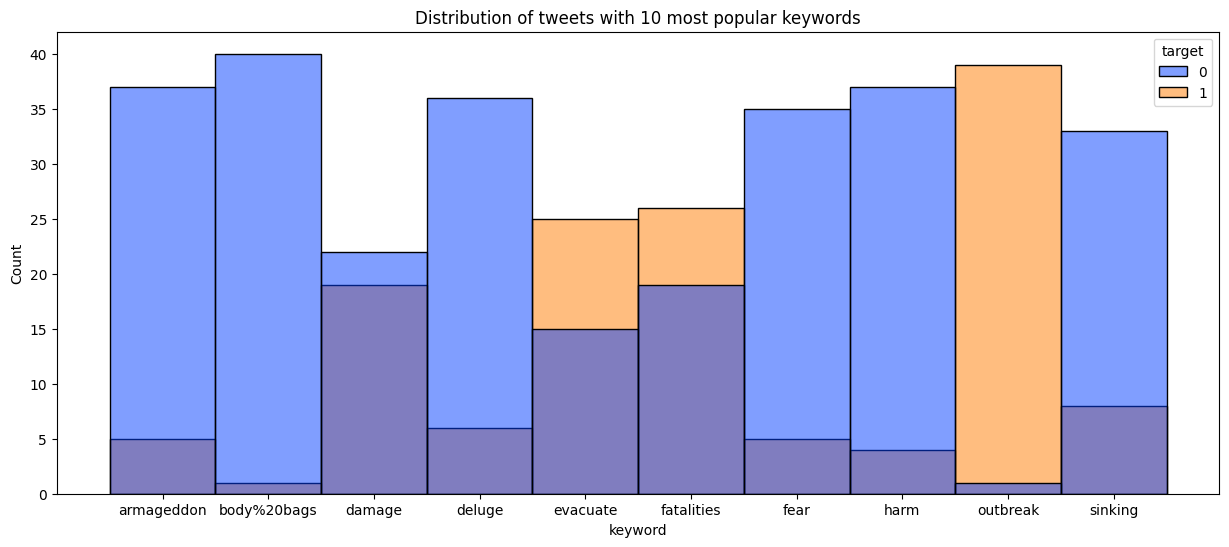

In [22]:
plt.figure(figsize=(15, 6))
plt.title('Distribution of tweets with 10 most popular keywords')

sns.histplot(data_popular, x='keyword', hue='target', palette='bright')

plt.show()

**Выводы**:

1) Можно заметить, что фейковых твитов здесь сильно больше, только в 3 из 10 случаев, а именно для ключевых слов *evacuate, fatalities, outbreak*, правдивых твитов больше

2) Значительное превалирование фейков видно у совсем кликбейтных и броских слов по типу *armageddon, body bags, deluge*. А если твит содержит слово *outbreak*, то почти гарантированно он правдивый

3) Примерно одинаковое распределение для стандартных и не таких броских слов, а именно *damage, evacuate, fatalities*

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [23]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,NaN,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


Почему мы делили выборку на тестовую и тренировочную до заполнения пропусков и склеивания столбцов это конечно очень интересный вопрос...

Поэтому оберну это в функцию чтобы потом применить и на тесте

In [24]:
def fill_and_conc(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.drop('id', axis=1).fillna('')

    df_new['text'] = df_new['keyword'] + ' ' + df_new['location'] + ' ' + df_new['text']
    return df_new.drop(['keyword', 'location'], axis=1)

In [25]:
train_new = fill_and_conc(train)

In [26]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()

tokens = cnt_vec.fit_transform(train_new['text'])
tokens.shape

(5329, 18455)

Размер матрицы довольно большой (получили около 18к токенов), но для NLP это еще лайтово

Cамих текстов же 5329

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [28]:
import re

def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return not not re.search(r'\d', s)

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return not not re.search(rf'[{punctuation}]', s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return not not re.search(r'^#.+', s)

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return not not re.search(r'^@.+', s)

def investigate_vocabulary(vocabulary):
    keys = vocabulary.keys()
    print('With digit:      ', sum(map(contains_digit, keys))
          )
    print('With punctuation:', sum(map(contains_punctuation, keys))
          )
    print('Hashtags:        ', sum(map(is_hashtag, keys))
          )
    print('Mentions:        ', sum(map(is_mention, keys))
          )
    

Теперь пояснения :)
- Регулярки это как наиболее правильный спобоб, никаких брутфорсов по крайней мере
- `not not` вместо `bool()` хорошо поясняется в видосе mCoding (если вкратце - это быстрее, потому что вызов функции - дорогая операция). Но на самом деле это оч спорная тема
- делать `lstrip()` вроде необязательно (для проверки # и @), потому что `CountVectorizer` убирает все пробелы из токенов 
- использовал стандартные питоновские функции `sum` и `map`, потому что нампай массивы работают только с чиселками

In [29]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [30]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


Видим, что слов с хэштегами и упоминаниями нет (наверное потому что у `CountVectorizer` под капотом примитивный токенайзер). Поэтому выведем только сообщения, содержащие цифры и знаки препинания. Если нужно сделать так и для других условий, нужно просто подставить нужную функцию фильтра

In [31]:
msg_with_dig = list(filter(contains_digit, cnt_vec.vocabulary_))
msg_with_punc = list(filter(contains_punctuation, cnt_vec.vocabulary_))
print(msg_with_dig[:10])
print(msg_with_punc[:10])

['20collapse', '2015', '60', 't5trhjuau0', 'b1g', 'bmurph1019', 'termn8r13', 'oaskgki6qj', 'di8elzswnr', '20accident']
['hail_youtsey', 'û_', '_gaabyx', 'early__may', 'til_now', 'marc_holl', 'mathew_is_angry', 'z3ke_sk1', 'derailed_benchmark', 'chubbysquirrel_']


Видим, что к пунктуации относятся нижние подчеркивания. Если же их не брать в расчет, то можно убедиться, что других знаков пунктуации нет

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [32]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer


def tokenizer(text: str) -> List[str]:
    return TweetTokenizer().tokenize(text)

In [33]:
cnt_vec2 = CountVectorizer(tokenizer=tokenizer)
toks = cnt_vec2.fit_transform(train_new['text'])

list(cnt_vec2.vocabulary_.keys())[:20]

['bridge',
 '%',
 '20collapse',
 'ashes',
 '2015',
 ':',
 'australia',
 '\x89',
 'ûªs',
 'collapse',
 'at',
 'trent',
 'among',
 'worst',
 'in',
 'history',
 'england',
 'bundled',
 'out',
 'for']

In [34]:
investigate_vocabulary(cnt_vec2.vocabulary_)

With digit:       3939
With punctuation: 7337
Hashtags:         1469
Mentions:         1678


**Сравнение:**

Теперь мы видим, что токенов стало прям сильно больше. Число токенов с цифрами увеличилось почти незаметно, но остальных прям сильно больше. 

Хештегов и упоминаний стало больше, потому что справедливости ради под это `TweetTokenizer` и заточен

А если говорить о пунктуации, то:
- хэштеги и упоминания - подмножества пунктуации (видно если вывести `string.punctuation`)
- дефолтный токенайзер по-видимому сильно чистит пунктуацию, но `TweetTokenizer`, к примеру, оставляет ссылки целиком, да и в целом не такой жесткий (в токенах можно найти `!`, `&` и.т.п) 

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [35]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# nltk.download('stopwords');

In [36]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return not not re.search(r'^[a-zA-Z]+$', s)

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return not not re.search(rf'^[{punctuation}]*[()]+[{punctuation}]*$', s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return not not re.search(r'^#[a-zA-Z]+$', s)

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    stopset = set(stopwords.words('english'))

    s_new = s.lower()
    tokens = TweetTokenizer().tokenize(s_new)
    filtered_tokens = filter(lambda x:
                             contains_only_latin_letters(x) or 
                             is_emoji(x) or 
                             is_hashtag(x), 
                             tokens)

    filtered_tokens = filter(lambda x: x not in stopset, filtered_tokens)

    return [SnowballStemmer('english').stem(t) for t in filtered_tokens]
  

Пояснения:
- чтобы матчить строки которые содеражт **только** определенные символы, необходимо добавлять ^ и $ как начало и конец строки. Иначе будет триггериться на первый допустимый символ, а остальные игнорить

- эмодзи матчатся по приципу:
    - любое количество символов пунктуации
    - обязательно одна из скобок (круглых, потому что эмозди с квадратными и фигурными я ни разу не видел)
    - любое количество символов пунктуации после матча скобки


- делал удаление стопслов отдельно, потому что после очистки могут появиться новые токены-стопслова. И если при этом делать проверку в той же лямбда-функции, то можно пропустить такие случаи и стоп слова все так же заматчатся

In [37]:
print(custom_tokenizer('She LOVES painting :-) #art'))

['love', 'paint', ':-)', '#art']


Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [38]:
first10 = train_new[:10]
texts = first10['text'].to_list()
tokens = first10['text'].apply(custom_tokenizer).to_list()

for text, token in zip(texts, tokens):
    print(text, token, '', sep='\n')

bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']

hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']

police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']

rioting  Still rioting in a couple of hours left until I have to be up for class.
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']

wounds Lake Highlands Crack in the path where I wiped out this morning during beach run. Surface wounds on le

Пришлось заюзать `for`, потому что в датафреймах для длинных массивов токенов они схлопываются, поэтому видно не все значения. Простите ((

Ну а так действительн видим, что остались либо чистые строки с английскими буквами, либо хэштеги (`#goblu`, `#wrestleton`), либо смайлики: `)`, `(`

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


Сначала подготовим выборки

In [39]:
train_new = fill_and_conc(train)
test_new = fill_and_conc(test)

y_train, y_test = train_new['target'], test_new['target']

train_new.drop('target', axis=1, inplace=True)
test_new.drop('target', axis=1, inplace=True)

In [40]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

bow_train = vectorizer.fit_transform(train_new['text'])
bow_test = vectorizer.transform(test_new['text'])

2. Обучите LogisticRegression на полученных признаках.


In [41]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=200, random_state=42)

logreg.fit(bow_train, y_train);

3. Посчитайте метрику f1-score на тестовых данных.

In [42]:
from sklearn.metrics import f1_score

pred = logreg.predict(bow_test)

print('Matrix shape:', bow_train.shape)
print('F1 Test score:', f1_score(y_test, pred))

Matrix shape: (5329, 10481)
F1 Test score: 0.7533584094572812


Видим, что при этом токенизаторе имеем уже 10к токенов

F1-мера получилась 0.753, что пока что такое себе, но в ласт задании это и просят :)

## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


Так как аналогичные действия (задание 8) будем делать еще несколько раз, для удобства сделаем функцию `fit_and_predict` 

In [43]:
def fit_and_predict(train: pd.DataFrame, test: pd.DataFrame, vectorizer, quiet: bool = False) -> Tuple[Tuple[int, int], float]:
    bow_train = vectorizer.fit_transform(train['text'])
    bow_test = vectorizer.transform(test['text'])

    logreg = LogisticRegression(max_iter=200, random_state=42)
    logreg.fit(bow_train, y_train)

    pred = logreg.predict(bow_test)

    shape = bow_train.shape
    f1 = f1_score(y_test, pred)
    
    if not quiet:
        print('Matrix shape:', shape)
        print('F1 Test score:', f1)

    return shape, f1

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

fit_and_predict(train, test, vectorizer=tfidf);

Matrix shape: (5329, 9260)
F1 Test score: 0.7418803418803419


1. **Ответ:** 

F1-мера ухудшилась, но не сильно (буквально на одну сотую)

Число токенов тоже сократилось, но ненамного (примерно на тысячу). Но если смотреть относительно, то это целых 10% от выборки

Трейд 1% качества на 10% прироста производительности звучит в целом нелохо

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [45]:
tfidf2 = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)

fit_and_predict(train, test, vectorizer=tfidf2);

Matrix shape: (5329, 9260)
F1 Test score: 0.7418803418803419


2. **Ответ:**

Что результат, что число токенов осталось таким же

Это связано с тем, что мы предварительно почистили тексты от стоп-слов. То есть слов, которые встречаются буквально в каждом документе ($df=0.9$), практически не осталось

Чтобы подобрать параметр `max_df` нужно брать значения поменьше. Попробуем подобрать такое.

Для подбора гиперпараметров создадим отдельную функцию. Она перебирает все пары гиперпараметров и выводит метрики для них

In [46]:
def test_dfs(min_df_list: Iterable = None, max_df_list: Iterable = None):
    f1_scores = []
    tokens_num = []
    all_mins = []
    all_maxs = []
    
    if min_df_list is None:
        min_df_list = [0.0]

    if max_df_list is None:
        max_df_list = [1.0]

    for min_df in min_df_list:
        for max_df in max_df_list:

            vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, 
                                         max_df=max_df, 
                                         min_df=min_df)
            
            shape, f1 = fit_and_predict(train, test, vectorizer=vectorizer, quiet=True)

            tokens_num.append(shape[1])
            f1_scores.append(f1)
            all_mins.append(min_df)
            all_maxs.append(max_df)

    result = pd.DataFrame({'min_df': all_mins,
                           'max_df': all_maxs, 
                           'Tokens': tokens_num, 
                           'F1 Score': f1_scores})
    display(result);

In [47]:
test_dfs(max_df_list=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5])

,min_df,max_df,Tokens,F1 Score
0,0.0,0.001,7724,0.446466
1,0.0,0.005,8941,0.673607
2,0.0,0.010,9152,0.702026
3,0.0,0.050,9259,0.743151
4,0.0,0.100,9260,0.741880
5,0.0,0.500,9260,0.741880


Странно, но даже даже при $max\_df = 0.1$ число токенов не меняется. Наверное, в корпусе слишком много уникальных слов. А при еще меньших значениях качество совсем ухудшается

Поэтому стандартное значение `max_df` является в данной задаче самым оптимальным

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [48]:
test_dfs(min_df_list=[0.001])

,min_df,max_df,Tokens,F1 Score
0,0.001,1.0,1536,0.742729


`min_df` очень тонкий гиперпараметр, его незначительное изменение может сильно поменять число токенов

Протестируем это задание для разных значений `min_df` и попробуем найти лучшее

Для начала определим порядок

In [49]:
test_dfs(min_df_list=[0.01, 0.001, 0.0001, 0.00001])

,min_df,max_df,Tokens,F1 Score
0,0.01000,1.0,108,0.631579
1,0.00100,1.0,1536,0.742729
2,0.00010,1.0,9260,0.741880
3,0.00001,1.0,9260,0.741880


Видим, что есть смысл тестить значения от 1e-3 до 1e-4

In [50]:
test_dfs(min_df_list=np.arange(0.0001, 0.0011, 0.0002))

,min_df,max_df,Tokens,F1 Score
0,0.0001,1.0,9260,0.741880
1,0.0003,1.0,4030,0.749153
2,0.0005,1.0,2788,0.755034
3,0.0007,1.0,2169,0.750140
4,0.0009,1.0,1792,0.748884


3. **Ответ:** 

Видим, что при $min\_df \simeq 0.0005$ получили наилучший реузультат в 0.755. Это совсем чуть чуть лучше, чем при аболютно стандартной и примитивной лемматизации

Однако я думаю, что подбирать его очень сложно и все зависит от конкретного корпуса текстов. Значение в 0.0005 не является каким-то интуитивным, поэтому этот гиперпараметр является сложным в подборе

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [51]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vec = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)

fit_and_predict(train, test, vectorizer=hash_vec);

Matrix shape: (5329, 5000)
F1 Test score: 0.7251864601262191


Как-то слабенько. Мб попробовать другие значения

In [52]:
nfs = range(2000, 11000, 2000)
f1s = []
for nf in nfs:
    hash_vec = HashingVectorizer(tokenizer=custom_tokenizer, n_features=nf)
    _, f1 = fit_and_predict(train, test, vectorizer=hash_vec, quiet=True)
    f1s.append(f1)

pd.DataFrame({'Features': nfs, 'F1 Score': f1s})

,Features,F1 Score
0,2000,0.703284
1,4000,0.707852
2,6000,0.724605
3,8000,0.726129
4,10000,0.731403


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** ну чето хваленый `HashingVectorizer` не сильно крутой. Даже подбирав параметры не получили чего-то крутого. F1 мера самая низкая среди всех предыдущих (0.725 при 5000 фич)

Самым лучшим на мой взгляд оказался `TfidfVectorizer` с подобранным гиперпараметрами. У него $F1 \simeq 0.755$, а также число токенов всего около 3 тысяч. Так смогли найти имбовый баланс между точностью и памятью. Но пришлось посидеть поподбирать гиперпараметры

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

Посмотрев семинар и немного поигравшись с параметрами получил такое оптимальное (больше на целую одну сотую KekW) решение:
- Использовать масштабирование признаков (`MaxAbsScaler`, потому что хорош для разреженных матриц)
- Использовать токенизатор `word_tokenizer`, не сильно ругающий за пунктуацию, а берущий ее как признак. В данной задаче это может быть применимо потому, что для супер фейковых новостей могут быть использованы, к примеру, куча восклицательных знаков или скобочек
- `TfidfVectorizer` как наиболее крутой по результатам тестирований выше. `min_df` также был подогнан

In [53]:
from sklearn.preprocessing import MaxAbsScaler
from nltk.tokenize import word_tokenize
#nltk.download('punkt')

scaler = MaxAbsScaler()

vect = TfidfVectorizer(tokenizer=word_tokenize, min_df=0.0002)

bow_train = vect.fit_transform(train['text'])
bow_test = vect.transform(test['text'])

bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

logreg = LogisticRegression(max_iter=200, random_state=42)
logreg.fit(bow_train, y_train)

pred = logreg.predict(bow_test)
print('F1 Score =', f1_score(y_test, pred))

F1 Score = 0.7598488936859147


Это конечно больше чем 0.75, даже почти 0.76. Не уверен что можно вытрясти что-то большее из данного датасета